In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3c
commitnumber = 5014a19
conc = 0.0004
dv = 0.01
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

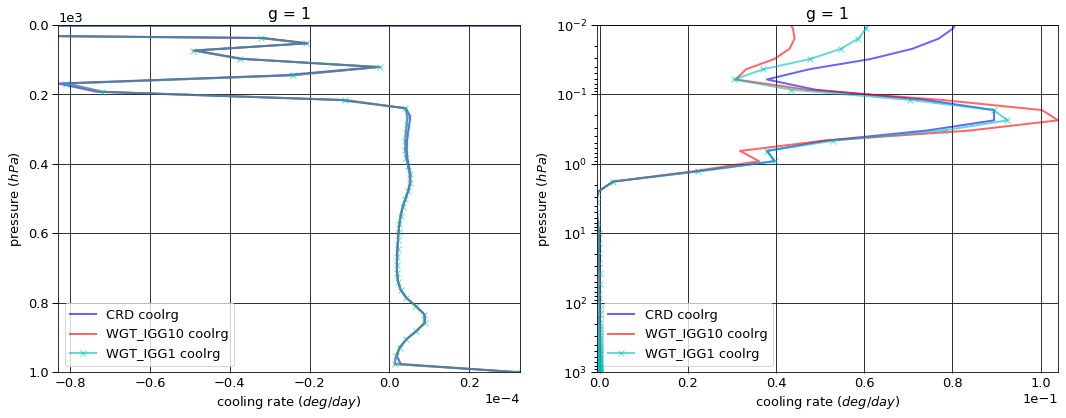

# Figure: cooling rate g-group 2

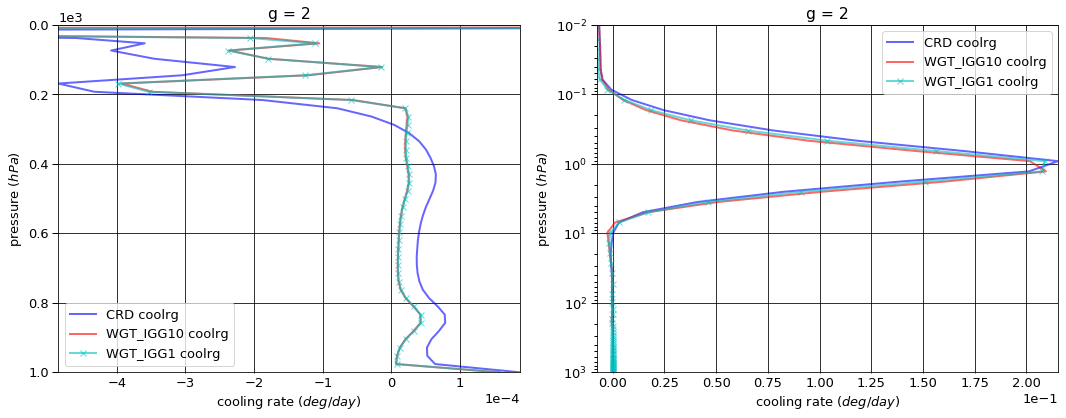

# Figure: cooling rate g-group 3

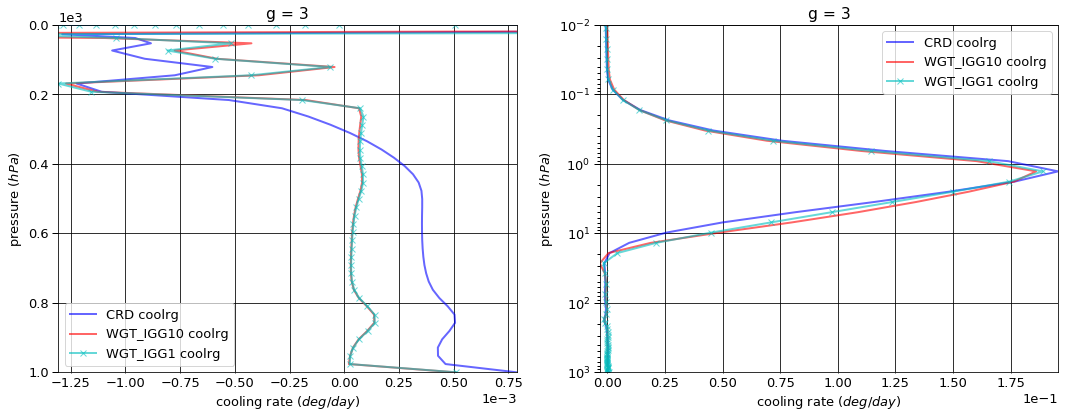

# Figure: cooling rate g-group 4

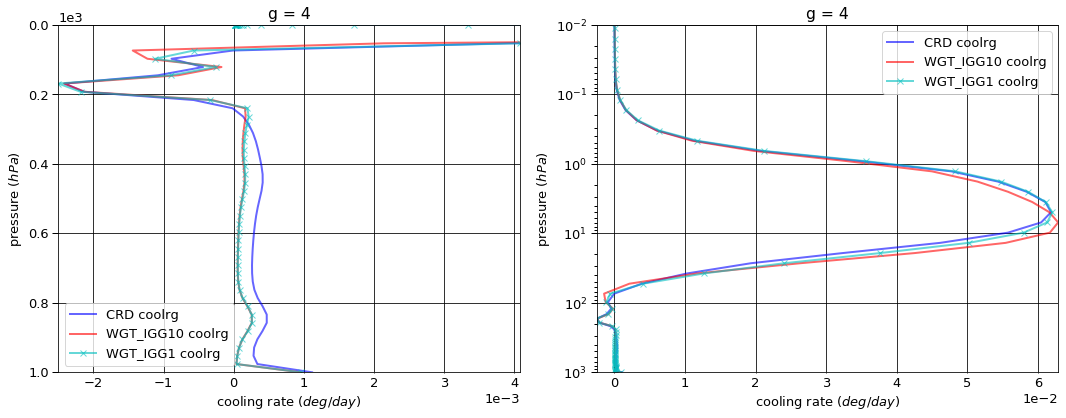

# Figure: cooling rate g-group 5

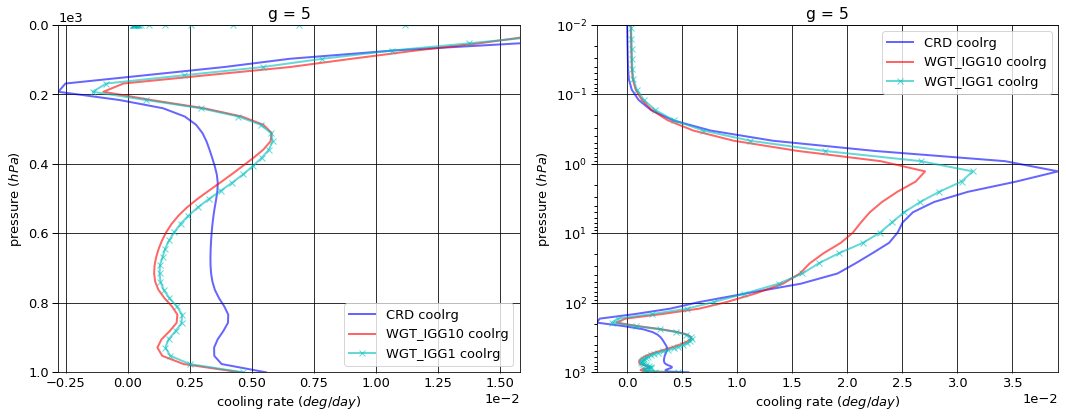

# Figure: cooling rate g-group 6

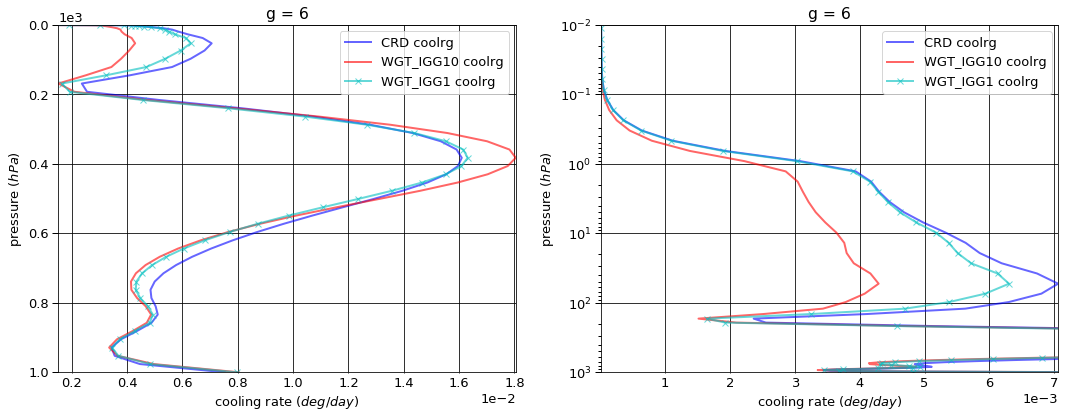

# Figure: cooling rate g-group 7

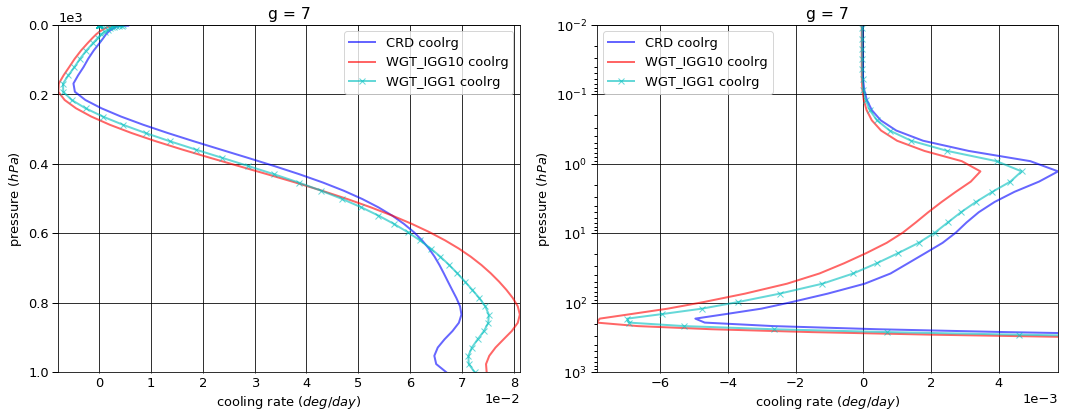

# Figure: cooling rate g-group 8

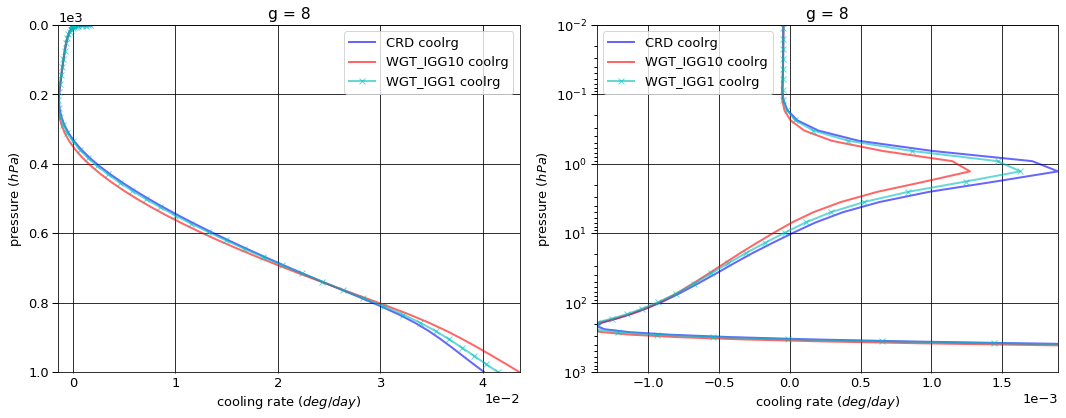

# Figure: cooling rate g-group 9

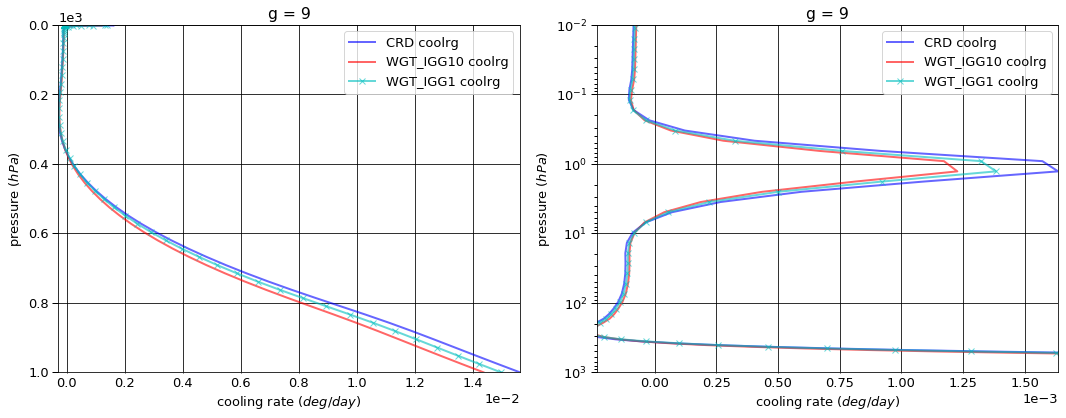

# Figure: cooling rate g-group total

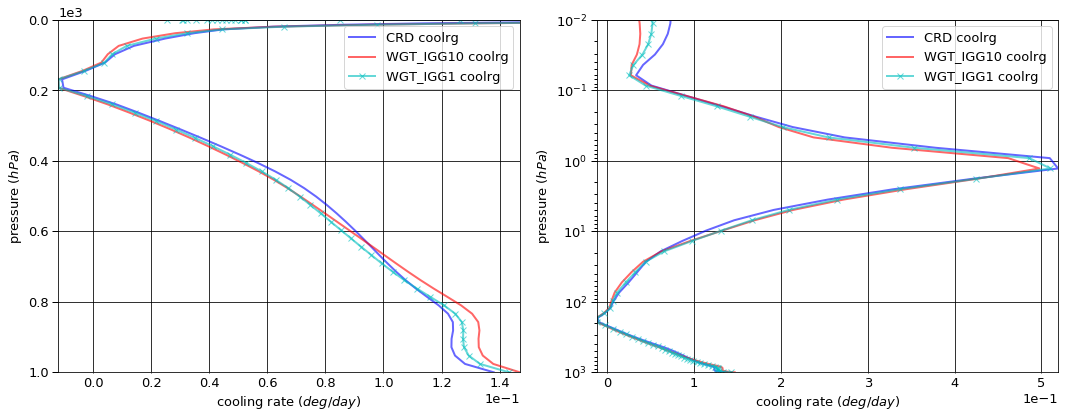

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.007023  0.000000  -0.007023
  1013.0   76     -0.016737  0.016641  -0.000096
2 0.0      1      -0.049758  0.000000  -0.049758
  1013.0   76     -0.079799  0.078421  -0.001378
3 0.0      1      -0.136880  0.000000  -0.136880
  1013.0   76     -0.259338  0.241665  -0.017672
4 0.0      1      -0.186390  0.000000  -0.186390
  1013.0   76     -0.487128  0.478995  -0.008133
5 0.0      1      -0.647411  0.000000  -0.647411
  1013.0   76     -1.569485  1.438178  -0.131308
6 0.0      1      -1.018172  0.000000  -1.018172
  1013.0   76     -2.495331  2.450605  -0.044726
7 0.0      1      -6.251719  0.000000  -6.251719
  1013.0   76     -9.345645  7.752487  -1.593158
8 0.0      1      -6.032831  0.000000  -6.032831
  1013.0   76     -6.602069  2.123773  -4.478297
9 0.0      1     -11.650980  0.000000 -11.650980
  1013.0   76    -11.782012  0.614196 -11.167816


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.006810  0.000000  -0.006810
  1013.0   76     -0.017061  0.016970  -0.000091
2 0.0      1      -0.051464  0.000000  -0.051464
  1013.0   76     -0.081626  0.081190  -0.000436
3 0.0      1      -0.130737  0.000000  -0.130737
  1013.0   76     -0.264451  0.263042  -0.001409
4 0.0      1      -0.180505  0.000000  -0.180505
  1013.0   76     -0.498197  0.495551  -0.002646
5 0.0      1      -0.482391  0.000000  -0.482391
  1013.0   76     -1.593929  1.572193  -0.021736
6 0.0      1      -0.977747  0.000000  -0.977747
  1013.0   76     -2.544997  2.500117  -0.044881
7 0.0      1      -6.392103  0.000000  -6.392103
  1013.0   76     -9.492155  7.947417  -1.544739
8 0.0      1      -6.043052  0.000000  -6.043052
  1013.0   76     -6.573153  2.093794  -4.479360
9 0.0      1     -11.459958  0.000000 -11.459958
  1013.0   76    -11.571974  0.544899 -11.027075


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.006951  0.000000  -0.006951
  1013.0   76     -0.017061  0.016970  -0.000091
2 0.0      1      -0.050902  0.000000  -0.050902
  1013.0   76     -0.081626  0.081185  -0.000441
3 0.0      1      -0.128648  0.000000  -0.128648
  1013.0   76     -0.264451  0.263018  -0.001433
4 0.0      1      -0.179040  0.000000  -0.179040
  1013.0   76     -0.498197  0.495531  -0.002666
5 0.0      1      -0.499494  0.000000  -0.499494
  1013.0   76     -1.593929  1.568968  -0.024962
6 0.0      1      -0.970349  0.000000  -0.970349
  1013.0   76     -2.544997  2.499012  -0.045985
7 0.0      1      -6.350707  0.000000  -6.350707
  1013.0   76     -9.492155  7.780988  -1.711167
8 0.0      1      -6.011370  0.000000  -6.011370
  1013.0   76     -6.573153  2.124702  -4.448451
9 0.0      1     -11.450728  0.000000 -11.450728
  1013.0   76    -11.571974  0.581193 -10.990781


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000213  0.000000  0.000213
  1013.0   76    -0.000324  0.000329  0.000005
2 0.0      1     -0.001706  0.000000 -0.001706
  1013.0   76    -0.001827  0.002769  0.000942
3 0.0      1      0.006142  0.000000  0.006142
  1013.0   76    -0.005113  0.021377  0.016264
4 0.0      1      0.005885  0.000000  0.005885
  1013.0   76    -0.011069  0.016556  0.005487
5 0.0      1      0.165020  0.000000  0.165020
  1013.0   76    -0.024444  0.134016  0.109572
6 0.0      1      0.040425  0.000000  0.040425
  1013.0   76    -0.049667  0.049512 -0.000155
7 0.0      1     -0.140383  0.000000 -0.140383
  1013.0   76    -0.146511  0.194930  0.048419
8 0.0      1     -0.010221  0.000000 -0.010221
  1013.0   76     0.028916 -0.029979 -0.001063
9 0.0      1      0.191022  0.000000  0.191022
  1013.0   76     0.210038 -0.069297  0.140741


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000072  0.000000  0.000072
  1013.0   76    -0.000324  0.000329  0.000005
2 0.0      1     -0.001144  0.000000 -0.001144
  1013.0   76    -0.001827  0.002764  0.000937
3 0.0      1      0.008232  0.000000  0.008232
  1013.0   76    -0.005113  0.021353  0.016240
4 0.0      1      0.007350  0.000000  0.007350
  1013.0   76    -0.011069  0.016536  0.005467
5 0.0      1      0.147917  0.000000  0.147917
  1013.0   76    -0.024444  0.130790  0.106346
6 0.0      1      0.047823  0.000000  0.047823
  1013.0   76    -0.049667  0.048408 -0.001259
7 0.0      1     -0.098987  0.000000 -0.098987
  1013.0   76    -0.146511  0.028501 -0.118009
8 0.0      1      0.021461  0.000000  0.021461
  1013.0   76     0.028916  0.000929  0.029846
9 0.0      1      0.200252  0.000000  0.200252
  1013.0   76     0.210038 -0.033003  0.177035

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.062782
  1001.112500 75     0.000033
2 0.000312    1     -0.008544
  1001.112500 75     0.000187
3 0.000312    1     -0.001479
  1001.112500 75     0.000788
4 0.000312    1      0.000002
  1001.112500 75     0.001117
5 0.000312    1     -0.000105
  1001.112500 75     0.005563
6 0.000312    1      0.000008
  1001.112500 75     0.007529
7 0.000312    1     -0.000031
  1001.112500 75     0.066997
8 0.000312    1     -0.000042
  1001.112500 75     0.040168
9 0.000312    1     -0.000075
  1001.112500 75     0.015623


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.021732
  1001.112500 75     0.000033
2 0.000312    1     -0.007832
  1001.112500 75     0.000157
3 0.000312    1     -0.000753
  1001.112500 75     0.000507
4 0.000312    1      0.000022
  1001.112500 75     0.000954
5 0.000312    1      0.000185
  1001.112500 75     0.004520
6 0.000312    1      0.000004
  1001.112500 75     0.008046
7 0.000312    1     -0.000049
  1001.112500 75     0.074773
8 0.000312    1     -0.000040
  1001.112500 75     0.043623
9 0.000312    1     -0.000065
  1001.112500 75     0.014369


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.041479
  1001.112500 75     0.000033
2 0.000312    1     -0.009432
  1001.112500 75     0.000158
3 0.000312    1     -0.001318
  1001.112500 75     0.000512
4 0.000312    1      0.000016
  1001.112500 75     0.000958
5 0.000312    1      0.000199
  1001.112500 75     0.004641
6 0.000312    1      0.000008
  1001.112500 75     0.007956
7 0.000312    1     -0.000041
  1001.112500 75     0.072466
8 0.000312    1     -0.000041
  1001.112500 75     0.041514
9 0.000312    1     -0.000071
  1001.112500 75     0.014971


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.105064e-02
  1001.112500 75     6.955300e-08
2 0.000312    1      7.118850e-04
  1001.112500 75    -3.053840e-05
3 0.000312    1      7.259327e-04
  1001.112500 75    -2.811233e-04
4 0.000312    1      2.028973e-05
  1001.112500 75    -1.628513e-04
5 0.000312    1      2.892752e-04
  1001.112500 75    -1.042624e-03
6 0.000312    1     -4.001505e-06
  1001.112500 75     5.173618e-04
7 0.000312    1     -1.802409e-05
  1001.112500 75     7.776451e-03
8 0.000312    1      1.789515e-06
  1001.112500 75     3.454964e-03
9 0.000312    1      9.935665e-06
  1001.112500 75    -1.254279e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.130380e-02
  1001.112500 75     1.147830e-07
2 0.000312    1     -8.882626e-04
  1001.112500 75    -2.963273e-05
3 0.000312    1      1.608661e-04
  1001.112500 75    -2.768070e-04
4 0.000312    1      1.389444e-05
  1001.112500 75    -1.591020e-04
5 0.000312    1      3.038784e-04
  1001.112500 75    -9.219924e-04
6 0.000312    1      1.869339e-07
  1001.112500 75     4.277144e-04
7 0.000312    1     -9.857624e-06
  1001.112500 75     5.468812e-03
8 0.000312    1      6.766230e-07
  1001.112500 75     1.346312e-03
9 0.000312    1      4.752058e-06
  1001.112500 75    -6.519540e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.981164,0.000000,-25.981164
1013.0,76,-32.637543,15.194959,-17.442583



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.724766,0.000000,-25.724766
1013.0,76,-32.637543,15.515172,-17.122371



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.648188,0.000000,-25.648188
1013.0,76,-32.637543,15.411567,-17.225976



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.563979e-01,0.000000,0.256398
1013.0,76,-2.070000e-07,0.320212,0.320212



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.329766e-01,0.000000,0.332977
1013.0,76,-2.070000e-07,0.216607,0.216607


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.052518
1001.112500,75,0.138005



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.013204
1001.112500,75,0.146983



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.030800
1001.112500,75,0.143209



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.039314
1001.112500,75,0.008977



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.021718
1001.112500,75,0.005203


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000500,0.000523
2,0.002375,0.002501
3,0.007750,0.008103
4,0.014500,0.015265
5,0.047125,0.048837
6,0.074500,0.077978
7,0.280500,0.290835
8,0.203250,0.201399
9,0.369500,0.354560


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.605800e-20
2,1.010006e-20
3,1.061976e-21
4,9.391186e-22
5,1.030873e-22
6,4.670600e-22
7,5.457807e-23
8,6.377695e-24
9,2.959362e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.605800e-20,NaN,0.000500,0.000523,0.000500,0.000523,1.0
2,1.010006e-20,0.105145,0.002375,0.002501,0.002875,0.003024,1.0
3,1.061976e-21,0.105145,0.007750,0.008103,0.010625,0.011126,1.0
4,9.391186e-22,0.884313,0.014500,0.015265,0.025125,0.026391,10.0
5,1.030873e-22,0.109770,0.047125,0.048837,0.072250,0.075228,10.0
6,4.670600e-22,4.530723,0.074500,0.077978,0.146750,0.153206,500.0
7,5.457807e-23,0.116855,0.280500,0.290835,0.427250,0.444041,500.0
8,6.377695e-24,0.116855,0.203250,0.201399,0.630500,0.645440,500.0
9,2.959362e-25,0.046402,0.369500,0.354560,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
